In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import random as rand
from numpy import linalg as lin
import random
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from cs771 import utils
from keras.datasets import mnist

Using TensorFlow backend.


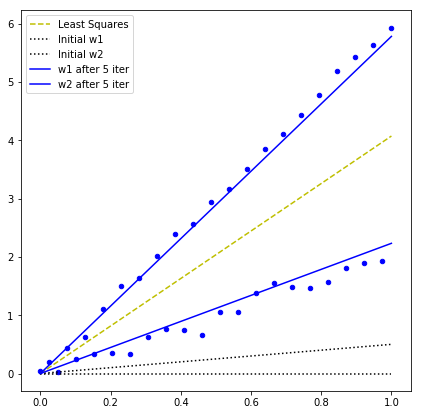

In [3]:
def doLSReg( X, y, weights = [] ):
    # If no weights are specified, do usual least squares
    if len(weights) == 0:
        return 1/(np.sum( np.square( X ))) * X.dot( y )
    # Else if weights are specified, solve the weighted least squares problem
    else:
        return 1/(weights.dot( np.square( X ))) * X.dot( np.multiply( weights, y ) )

def doEStep( X, y, wVals ):
    residuals = np.matmul( X[:,np.newaxis], wVals[np.newaxis,:] ) - y[:,np.newaxis]
    qVals = np.exp( -np.square( residuals ) / 2 )
    rowSum = qVals.sum( axis = 1 )
    qVals = qVals / rowSum[:, np.newaxis]
    return qVals

def doMStep( X, y, qVals, C, prevWVals ):
    wVals = np.zeros( prevWVals.shape )
    
    # Process every component
    for c in range( C ):
        # Get hold of the weights different data points have given to this component
        q = qVals[:, c]
        amountData = sum(q)
        # If there is enough data for this component, do weighted least squares to get the weighted MLE
        if amountData > 1:
            wVals[c] = doLSReg( X, y, weights = q )
        # If some cluster is almost empty, return the old value of the model for this component
        else:
            wVals[c] = prevWVals[c]
    return wVals

def doEMMR( X, y, C, init, niter ):
    wVals = init
    for t in range( niter ):
        qVals = doEStep( X, y, wVals )
        wVals = doMStep( X, y, qVals, C, wVals )
    return (wVals, qVals)

n = 40

X = np.linspace( 0, 1, n, endpoint = True )
wAst1 = 2
wAst2 = 6
noise = rand.normal( 0, 0.1, (n,) )
y = np.zeros( X.shape )
y[::2] = X[::2] * wAst1
y[1::2] = X[1::2] * wAst2
y = y + noise

wHat = doLSReg( X, y )

fig = pd.getFigure( 7, 7 )
pd.plot2D( np.hstack( (X[:, np.newaxis], y[:, np.newaxis]) ), fig, color = 'b', marker = 'o', size = 20 )
pd.plotLine( np.array( [wHat, -1] ) , 0, fig, color = 'y', linestyle = "--", xlimL = 0, xlimR = 1, label = "Least Squares" )

# Careful initialization is required here, just as it was for (soft) k-means
# If we initialize both models to be equal in the beginning, then the procedure cannot learn two components
# Try setting, for example, init = np.array( [1,1] ) and see for yourself
init = np.array( [0,0.5] )
pd.plotLine( np.array( [init[0], -1] ) , 0, fig, color = 'k', linestyle = ":", xlimL = 0, xlimR = 1, label = "Initial w1" )
pd.plotLine( np.array( [init[1], -1] ) , 0, fig, color = 'k', linestyle = ":", xlimL = 0, xlimR = 1, label = "Initial w2" )

# The EM algorithm is very quick at identifying that there are two populations in the data
# Within very few iterations, it converges to the two models
C = 2
niter = 5
(wVals, qVals) = doEMMR( X, y, C, init, niter)

pd.plotLine( np.array( [wVals[0], -1] ) , 0, fig, color = 'b', linestyle = "-", xlimL = 0, xlimR = 1, label = "w1 after %s iter" % niter )
pd.plotLine( np.array( [wVals[1], -1] ) , 0, fig, color = 'b', linestyle = "-", xlimL = 0, xlimR = 1, label = "w2 after %s iter" % niter )

Prediction Accuracy:  0.8573


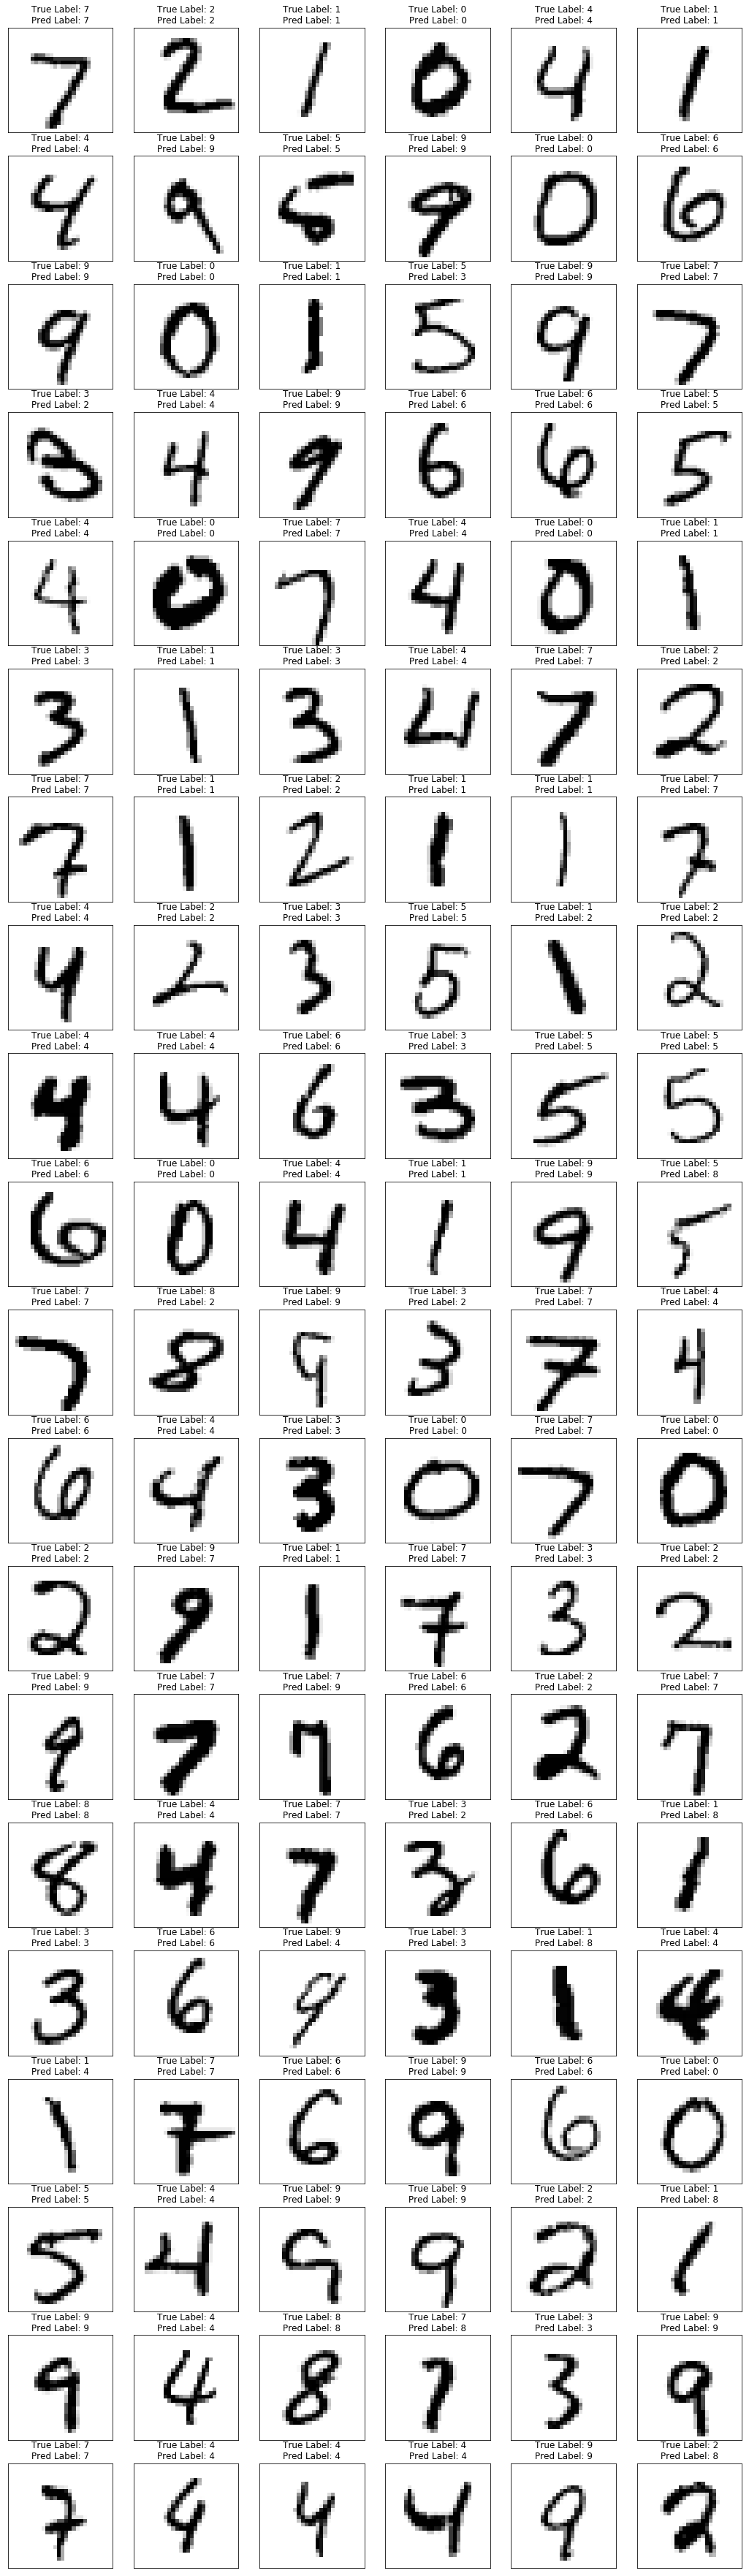

In [4]:
# Learn a single (general) Gaussian per class
def learnClassConditionalDist( X, y ):
    (labels, labelCounts) = np.unique( y, return_counts = True )
    C = labels.size
    (n, d) = X.shape
    muVals = np.zeros( (C, d) )
    SigmaVals = np.zeros( (C, d, d) )
    for c in range( C ):
        XThisLabel = X[y == c]
        # MLE for mean is simply the empirical mean (aka sample mean) of feature vectors of this class
        muVals[c] = np.mean( XThisLabel, axis = 0 )
        XCent = XThisLabel - muVals[c]
        # MLE for covariance matrix is simply the empirical/sample covariance matrix of this class
        SigmaVals[c] = 1/labelCounts[c]*(XCent.T).dot( XCent )
    return (C, list( zip( muVals, SigmaVals, np.arange( C ), labelCounts/n ) ))

# Stretch out the 28 x 28 image into a 784 dimensional vector
def flattenTensor( X ):
    n = X.shape[0]
    d = np.prod( X.shape[1:] )
    return X.reshape( n, d )

def predictClassScores( X, mu, Sigma, p, mask = [] ):
    # If no mask was provided, then we need to consider all coordinates of the feature vector
    if len(mask) == 0:
        mask = np.ones( (X.shape[1],), dtype=bool )
    
    XCent = X[:,mask] - mu[mask]
    # The covariance matrix will mostly be non-invertible in this case
    # This is because some pixels are always white in every image i.e. zero variance
    # The Moore-Penrose "pseudoinverse" is used in such situations
    SInv = lin.pinv( Sigma[mask,:][:,mask] )
    # numpy has a helpful routine that directly calculates the logdet of a matrix
    # More numerically stable in several situations -- no exploding outputs
    (sign, logdet) = lin.slogdet( Sigma[mask,:][:,mask] )
    # sign = 0 is the routines way of telling us that the determinant was zero
    # The determinant of a covariance matrix should always be non-negative
    if sign <= 0:
        SLogDet = 0
    else:
        SLogDet = logdet
    # This term gives us (ignoring additive constants) ln P[x | y, \theta]
    term1 = 0.5 * (-SLogDet - np.sum( np.multiply( np.dot(XCent, SInv), XCent), axis = 1 ))
    # This term gives us ln P[y | \theta]
    term2 = np.log( p )
    return term1 + term2

def predictGen( X, model, C, mask = [] ):
    classScores = np.zeros( (X.shape[0], C) )
    for mu, Sigma, c, p in model:
        classScores[:,c] = predictClassScores( X, mu, Sigma, p, mask )
    return np.argmax( classScores, axis = 1 )

((XTrain, yTrain), (XTest, yTest)) = mnist.load_data()

# Normalize data coordinates otherwise numbers in later calculations explode
# Also, flatten images for sake of convenience
imShape = XTrain.shape[1:]
XTrainFlat = flattenTensor( XTrain/256 )
XTestFlat = flattenTensor( XTest/256 )

(C, model) = learnClassConditionalDist( XTrainFlat, yTrain )
yPred = predictGen( XTestFlat, model, C )

print( "Prediction Accuracy: ", sum(yPred == yTest)/yTest.size )

numRows = 20
numCols = 6

fig2, axs2 = pd.getFigList( numRows, numCols, sizey = 3.2 )
labels = ["True Label: %s\nPred Label: %s" % (yTest[i], yPred[i]) for i in range( numRows * numCols )]
pd.showImagesNoAxes( axs2, XTestFlat[:numRows*numCols], numRows, numCols, resize = True, imShape = imShape, labelList = labels )

Prediction Accuracy on Censored Images:  0.814


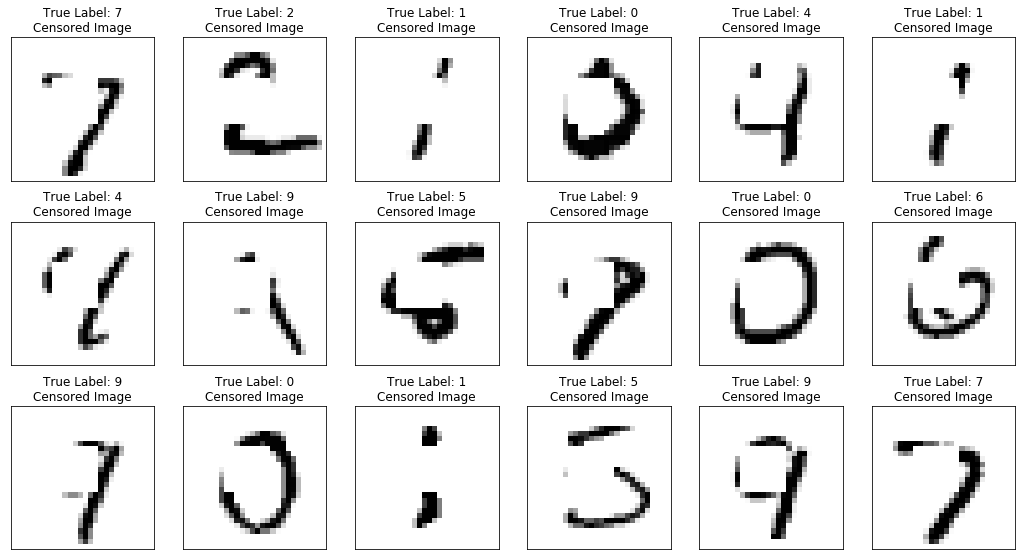

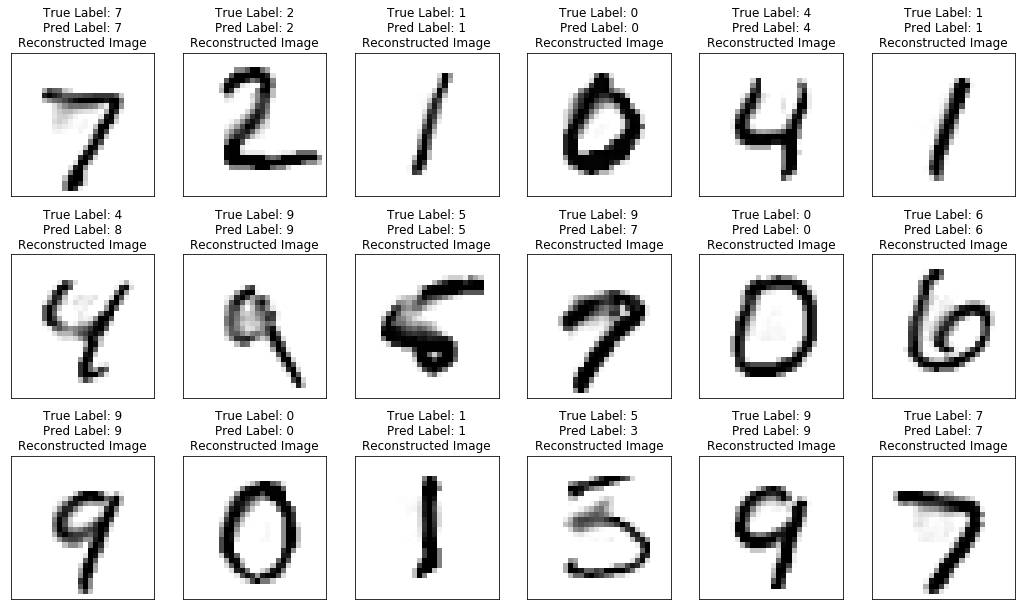

In [5]:
# You may yry more aggressive censoring e.g. X[:, 5:20, 5:20] = 0 which wipes out 25% of the pixels
# Accuracy will fall as we wipe out more and more pixels
def censorImages( X ):
    # Wipe out 10% of the pixels from the central part of the image
    X[:, 8:17, 8:17] = 0
    return X

# Warning: if we completely wipe out the images e.g. X[:, :, :] = 0, even then we will get ~11% accuracy
# This is because the all white image gets classified as the digit 1 due to the image 1 being relatively
# popular in the database as well as due to the digit 1 having the most number of white pixels anyway

# Make sure that reconstructed image does not have any negative-valued pixels
def truncatePixels( X, low = 0, high = 1 ):
    X[X < low] = low
    X[X > high] = high
    return X

# Reconstruct the image using the Gaussian conditionals
def reconstructImages( X, yPred, model, mask ):
    XRecon = np.zeros( X.shape )
    # Pixels observed are used as is in the reconstruction
    XRecon[:, mask] = X[:, mask]
    for i in range( X.shape[0] ):
        ( mu, Sigma, c, p ) = model[yPred[i]]
        recon = mu[~mask] + Sigma[~mask,:][:,mask].dot( lin.pinv( Sigma[mask,:][:,mask] ).dot( (XRecon[i,mask] - mu[mask]) ) )
        XRecon[i, ~mask] = recon
    return truncatePixels( XRecon )

XTestCensorFlat = flattenTensor( censorImages( XTest ) / 256 )
mask = flattenTensor( censorImages( np.ones( imShape )[np.newaxis, :] ) )[0] == 1

yPred = predictGen( XTestCensorFlat, model, C, mask )

print( "Prediction Accuracy on Censored Images: ", sum(yPred == yTest)/yTest.size )

numRows = 3
numCols = 6

XTestReconFlat = reconstructImages( XTestCensorFlat[:numRows*numCols], yPred[:numRows*numCols], model, mask )

fig3, axs3 = pd.getFigList( numRows, numCols, sizey = 3.2 )
labels = ["True Label: %s\nCensored Image" % yTest[i] for i in range( numRows * numCols )]
pd.showImagesNoAxes( axs3, XTestCensorFlat[:numRows*numCols], numRows, numCols, resize = True, imShape = imShape, labelList = labels )

fig4, axs4 = pd.getFigList( numRows, numCols, sizey = 3.5 )
labels = ["True Label: %s\nPred Label: %s\nReconstructed Image" % (yTest[i], yPred[i]) for i in range( numRows * numCols )]
pd.showImagesNoAxes( axs4, XTestReconFlat[:numRows*numCols], numRows, numCols, resize = True, imShape = imShape, labelList = labels )